In [55]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# EDA библиотеки
import statistics as stcs

# библиотека для расчетов корреляций
from scipy import stats

# скрытие сообщений об ошибках при обработке ответов
import warnings
warnings.filterwarnings('ignore')

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

# <center> Домашнее задание

Используя информацию по мидиям Петербурга и Магадана, которые представлены в виде двух массивов *petersburg* и *magadan*, проверьте данные на нормальность и на наличие корреляции. 

Для этого:

* Объедините два массива в DataFrame. 
* Обоснуйте выбор теста на корреляцию. 
* Сделайте вывод по гипотезе.
* Ответьте на вопрос: <font color='LightSeaGreen'>**Какова разница в среднем размере мидии в зависимости от города-производителя**</font>
* Обоснуйте выбор теста. 
* Сделайте вывод по гипотезе.

# <center> Создание Dataframe

In [56]:
# исходные данные по размерам мидий
mussels_spb = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
mussels_mgdn = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764, 0.0689]

In [57]:
# формируем массивы данных
df_spb = pd.DataFrame({'spb': mussels_spb})
df_mgdn = pd.DataFrame({'mgdn': mussels_mgdn})

# создаём общий датафрейм
df = pd.concat([df_spb, df_mgdn], axis=1)

# т.к. массивы значений разной длины, то Nan-значения подвергнуты обработке
# заменяем пропущенное NaN-значение медианным
df.fillna(stcs.median(df['spb']).__round__(4), inplace=True)

# проверяем данные
df

,spb,mgdn
0,0.0974,0.1033
1,0.1352,0.0915
2,0.0817,0.0781
3,0.1016,0.0685
4,0.0968,0.0677
5,0.1064,0.0697
6,0.1050,0.0764
7,0.1033,0.0689


# <center> Тест на нормальность

## <center> <font color='LightSeaGreen'>Тест Шапиро-Уилка</font>

Тест проверяет, имеет ли выборка данных распределение Гаусса (нормальное, в виде "колокола").<br> Если полученная с его помощью статистическая значимость (*P-value*) больше уровня значимости, то мы не вправе отвергать нулевую гипотезу:

In [58]:
# нулевая гипотеза
H_0 = 'Данные имеют гауссово распределение'

# альтернативная гипотеза
H_a = 'Данные не имеют гауссовского распределения'

# уровень значимости
alpha = 0.05

In [59]:
# статистическая значимость для теста Шапиро-Уилка (для мидий из Санкт-Петербурга)
p_val_sh_wlks_spb = stats.shapiro(df['spb'])[1].__round__(4)

# интерпретация
if p_val_sh_wlks_spb > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_sh_wlks_spb}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_sh_wlks_spb}) меньше уровня значимости ({alpha})')

Мы не можем отвергнуть нулевую гипотезу. Данные имеют гауссово распределение, так как P-value (0.1218) больше уровня значимости (0.05)


In [60]:
# статистическая значимость для теста Шапиро-Уилка (для мидий из Магадана)
p_val_sh_wlks_mgdn = stats.shapiro(df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_sh_wlks_mgdn > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_sh_wlks_mgdn}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_sh_wlks_mgdn}) меньше уровня значимости ({alpha})')

Мы отвергаем нулевую гипотезу. Данные не имеют гауссовского распределения, так как P-value (0.0357) меньше уровня значимости (0.05)


Таким образом, по ***результатам теста Шапиро-Уилка*** данные столбца по мидиям из '*spb*' распределены нормально, а данные столбца '*mgdn*' не соответствуют нормальному распределению.

## <center> <font color='LightSeaGreen'>Тест Д'Агостино</font>

Метод *normaltest* модуля ***scipy*** в данном выдаёт предупреждение о действительности теста на эксцесс в связи с малой выборкой, **требуется выборка имеющая 20 и более значений** (в связи с этим, системное сообщение скрыто, "подавлено").

Данный тест является двусторонним, то есть рассчитывается статистическая значимость попадания как в левый, так и в правый хвост (эксцесс), поэтому для проверки нулевой гипотезы статистическую значимость (P-value) будем сравнивать с "половинной величиной" уровня значимости:

In [61]:
# статистическая значимость для теста Д'Агостино (для мидий из Магадана)
p_val_K_2 = stats.normaltest(df)[1][1].__round__(4)

# интерпретация
if p_val_K_2 > (alpha / 2):
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_K_2}) больше половины уровня значимости ({alpha / 2})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_K_2}) меньше половины уровня значимости ({alpha / 2})')

Мы не можем отвергнуть нулевую гипотезу. Данные имеют гауссово распределение, так как P-value (0.1543) больше половины уровня значимости (0.025)


## <center> <font color='LightSeaGreen'>Оценка плотности</font>

Проверим распределения данных визуально, на графике:

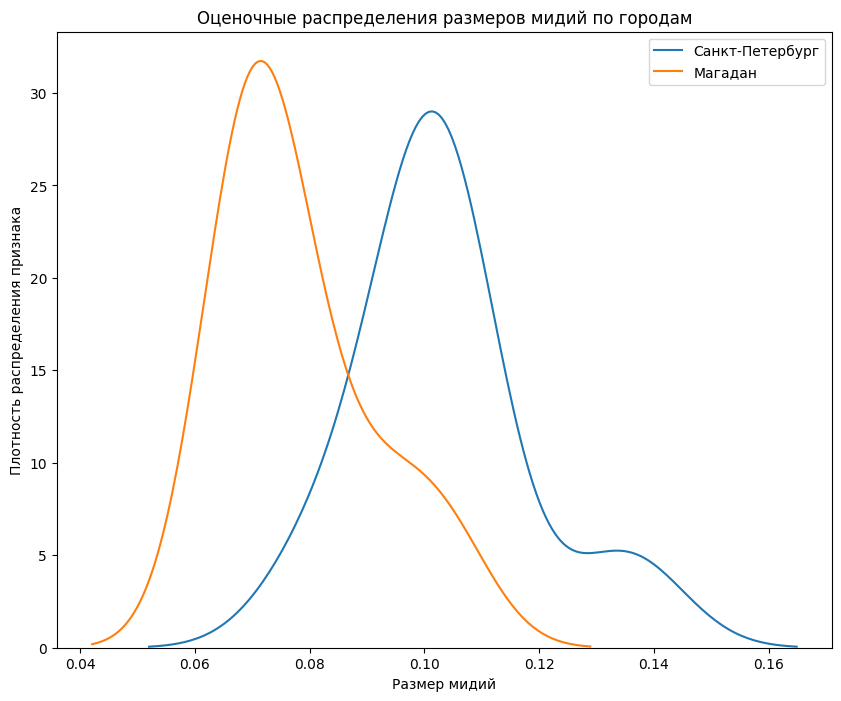

In [62]:
# параметры полотна и число графиков
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))

# задаем названия графика и осей
ax1.set_title('Оценочные распределения размеров мидий по городам')
ax1.set(xlabel='Размер мидий', ylabel='Плотность распределения признака')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['spb'], ax=ax1, label ='Санкт-Петербург')
sns.kdeplot(df['mgdn'], ax=ax1, label ='Магадан')

# отобразить легенду
plt.legend();

### **Выводы**:
1. Два списка, изначально, разной длины, в связи с этим тесты на нормальность проведены на каждом признаке отдельно, несколькими тестами;
2. В регионе Санкт-Петербург, имея всего 7 элементов без учета NaN, можем провести только тест Шапиро-Уилка (т.к. имеется предупреждение, что он не применим на малых выборках, у нас выборка менее 20 элементов), данные распределены нормально;
4. В регионе Магадан на тесте Шапиро-Уилка - *данные не распределены нормально*, тест Д’Агостино - **данные имеют нормальное распределение**, то ***принимаем, предварительно, версию о нормально распределённых данных***;
5. Кривые плотности распределений визуализируют, что **данные распределены нормально у обоих признаков**;
6. Принимая во внимание расчёты алгоритмов и визуальную составляющую графиков, <font color='LightSeaGreen'>***предварительно, исходим из того, что оба признака распределены нормально***</font>, но на всякий случай выполним параметрический и непараметрические тесты.

---

# <center> Корреляционные тесты. Обоснование выбора теста

1. Коэффициент корреляции Пирсона может быть рассчитан для непрерывных нормально распределённых признаков
2. Лучшим вариантом будет придерживаться правил корреляций каждого из методов:

    * для непрерывных нормально распределённых используем корреляцию Пирсона;

    * для категориальных — ранговую. 

    Так как у нас спорный случай, то рассмотрим ещё и вариант корреляции по Спирману, ведь, иногда мы можем применить ранговую корреляцию и для числовых переменных, которые распределены ***ненормально*** или если между ними существует нелинейная связь.<br> А у нас как раз такой неявный случай, а так как у нас количественные переменные в обоих выборках, то использование теста по Спирману в качестве корреляционного непараметрического теста обосновано.

## <center> <font color='LightSeaGreen'>Корреляция Пирсона</font>

In [63]:
# нулевая гипотеза
H_0 = 'Отсутствует взаимосвязь между переменными'

# альтернативная гипотеза
H_a = 'Взаимосвязь между переменными есть'

# уровень значимости
alpha = 0.05

In [64]:
# статистическая значимость для теста Пирсона
p_val_pearson = stats.pearsonr(df['spb'], df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_pearson > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_pearson}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_pearson}) меньше уровня значимости ({alpha})')

Мы не можем отвергнуть нулевую гипотезу. Отсутствует взаимосвязь между переменными, так как P-value (0.5578) больше уровня значимости (0.05)


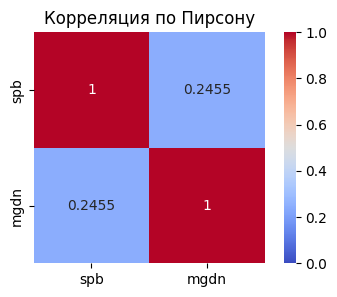

In [65]:
# визуализация матрицы корреляции по Пирсону
fig = plt.figure(figsize=(5, 3))
ax = sns.heatmap(
    df.corr(method='pearson', numeric_only=True), 
    annot = True, 
    fmt='.4g', 
    cmap='coolwarm', 
    square=True,
    vmin=0, 
    vmax=1,
)
ax.set_title("Корреляция по Пирсону");

## <center> <font color='LightSeaGreen'>Корреляция Спирмана</font>

In [66]:
# статистическая значимость для теста Спирмана
p_val_spearman = stats.spearmanr(df['spb'], df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_spearman > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_spearman}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_spearman}) меньше уровня значимости ({alpha})')

Мы не можем отвергнуть нулевую гипотезу. Отсутствует взаимосвязь между переменными, так как P-value (0.6932) больше уровня значимости (0.05)


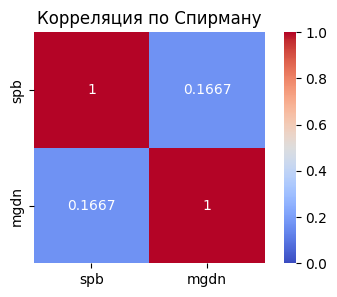

In [67]:
# визуализация матрицы корреляции по Смирману
fig = plt.figure(figsize=(5, 3))
ax = sns.heatmap(
    df.corr(method='spearman', numeric_only=True), 
    annot = True, 
    fmt='.4g', 
    cmap='coolwarm', 
    square=True,
    vmin=0, 
    vmax=1,
)
ax.set_title("Корреляция по Спирману");

### **Выводы**:

Оба теста свидетельствуют об отсутствии связи (очень слабой связи) между признаками (коэффициент корреляции < 0.3)

Корреляционные тесты использовать не совсем корректно, так как нет как таковых пар значений, данные в выборках не связаны кроме одного признака - это размер мидий. Целесообразно применять только тесты на сравнение выборок.

---

# <center> Сравнительные тесты выборок

In [68]:
# нулевая гипотеза
H_0 = 'Средние значения размеров раковин мидий, выращенных в 2 разных местах, равны'

# альтернативная гипотеза
H_a = 'Среднее значение размеров раковин мидий из одного места больше, чем из другого'

# уровень значимости
alpha = 0.05

На основании схемы предложенной в материалах обучения:

1. В качестве параметрического сравнительного теста, если исходить из того, что распределение данных близко к гауссовскому (нормальному распределению) - выбираем независимый t-критерий Стюдента (независимый t-тест). 
    
    Так как у нас:

    * 1 количественная переменная;

    * данные из разных совокупностей;

    * всего две группы для сравнения (магаданские и петербургские мидии);

    * выборки независимы друг от друга;

    * объём каждой выборки не превышает 30 элементов.

2. В качестве непараметрического сравнительного теста - выбираем U-критерий Манна-Уитни (сумма рангов Уилкоксона), принимая во внимание вышеперечисленные факты.

## <center> <font color='LightSeaGreen'>Параметрический тест.<br> t-критерий Стюдента (независимый t-тест)</font>

In [69]:
# статистическая значимость для t-критерия Стьюдента
p_val_t_test = stats.ttest_ind(df['spb'], df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_t_test > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_t_test}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_t_test}) меньше уровня значимости ({alpha})')

Мы отвергаем нулевую гипотезу. Среднее значение размеров раковин мидий из одного места больше, чем из другого, так как P-value (0.0027) меньше уровня значимости (0.05)


## <center> <font color='LightSeaGreen'>Непараметрический тест.<br> U-критерий Манна-Уитни (сумма рангов Уилкоксона)</font>

In [70]:
# статистическая значимость для U-критерия Манна-Уитни
p_val_mw_test = stats.mannwhitneyu(df['spb'], df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_mw_test > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_mw_test}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_mw_test}) меньше уровня значимости ({alpha})')

Мы отвергаем нулевую гипотезу. Среднее значение размеров раковин мидий из одного места больше, чем из другого, так как P-value (0.0063) меньше уровня значимости (0.05)


In [71]:
# статистическая значимость для теста "сумма рангов Уилкоксона"
p_val_w_rank_test = stats.ranksums(df['spb'], df['mgdn'])[1].__round__(4)

# интерпретация
if p_val_w_rank_test > alpha:
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_w_rank_test}) больше уровня значимости ({alpha})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_w_rank_test}) меньше уровня значимости ({alpha})')

Мы отвергаем нулевую гипотезу. Среднее значение размеров раковин мидий из одного места больше, чем из другого, так как P-value (0.0054) меньше уровня значимости (0.05)


Так как *P-value* теста ниже уровня значимости, результаты статистически значимы и согласуются с альтернативной гипотезой.

Найдём фактическую разницу средних значений мидий в зависимости от города происхождения:

In [72]:
(df.mean() * 100).round(2)

print(f"Разница средних размеров мидий составила {((df['spb'].mean() - df['mgdn'].mean())* 100).round(2)} см")

spb     10.34
mgdn     7.80
dtype: float64

Разница средних размеров мидий составила 2.54 см


### **Общие выводы по проекту:**

1. Выборка слишком мала, разной длины, образовавшийся пропуск - сильно не осложняет сильно работу, но может внести коррективы при использовании тестов;
2. Алгоритмы не дали однозначного явного представления о "нормальности выборки", поэтому выполнены сравнительные тесты обоих видов - и параметрические, и не параметрические;
3. Тесты на корреляцию показали отсутствие взаимосвязи между данными;
4. В Петербурге средний размер мидий составляет - 10,3 см, в Магадане - 7.8 см, разница, в среднем - ~2.5см